<H1>Predicting Authors from Sentences</H1>
<H3>Thinkful Supervised Learning Capstone Project by Michael Klear</H3>

<H2>About the Dataset</H2><br>
This dataset comes from a Kaggle competition. The challenge is to identify authors based on isolated sentences from their texts. The authors are three well-known horror writers:<br>

 - Edgar Allan Poe (1809-1849)
 - Mary W. Shelley (1797-1851)
 - H.P. Lovecraft (1890-1937)

The data consists of two tables: one labeled with the authors, and another with unlabeled sentences. The challenge is to make predictions on the test set.

<H2>Features:</H2>

  1. Sentence (string)<br>
  
<H2>Classes:</H2>
  1. EAP (Poe)
  2. MWS (Shelley)
  3. HPL (Lovecraft)

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss, make_scorer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import scipy
from collections import Counter
from time import time
from math import e

sns.set_style('darkgrid')
data = pd.read_csv('train.csv')
cls_balance = {}
for auth in data.author.unique():
    cls_balance[auth] = len(data[data.author==auth])

<H2>Training Set</H2>

In [2]:
print(
    'Poe samples: ', 
    cls_balance['EAP'], 
    ', {}% of training set.'.format(str(100*cls_balance['EAP']/len(data))[:4])
)
print(
    'Shelley samples: ', 
    cls_balance['MWS'], 
    ', {}% of training set.'.format(str(100*cls_balance['MWS']/len(data))[:4])
)
print(
    'Lovecraft samples: ', 
    cls_balance['HPL'], 
    ', {}% of training set.'.format(str(100*cls_balance['HPL']/len(data))[:4])
)
data.head(3)

Poe samples:  7900 , 40.3% of training set.
Shelley samples:  6044 , 30.8% of training set.
Lovecraft samples:  5635 , 28.7% of training set.


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP


<H2>Test Set</H2>

In [3]:
test = pd.read_csv('test.csv')
print('A sentence from test set: \n\n\t', test.iloc[1234].text)
test.head(3)

A sentence from test set: 

	 The trim and paled demesne of civilization, which I had before regarded from my wild jungle as inaccessible, had its wicket opened by him; I stepped within, and felt, as I entered, that I trod my native soil.


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...


<H1>Evaluation Metric</H1><br>
 - Kaggle uses <b>log loss</b> to evaluate predictions. 
 - Log loss measures both <b>accuracy</b> and <b>confidence</b> of predictions.

The predictive model takes a sentence and gives a probability for each author.<br><br>
where:<br>
$n$ is the set of all samples (sentences) in the test set, <br>
$m$ is the set of all classes (authors).<br>

for a given sentence $i$:<br>
$y_{ij}=1$ where $j$ is the correct class, else $y=0$<br>
$p_{ij} = $ the model's predicted probability that $j$ is the correct class<br>
log loss is defined as:


$$logloss=\sum_{i=0}^n\sum_{j=0}^m y_{i j} logp_{i j}$$<br>

A lower log loss is better. The lower limit is zero (best performance), and there is no upper limit.

<H3>Goal</H3><br>
Minimize the cross-validated log loss score of my model.<br>
<H3>Approach</H3><br>
Use an ensemble of models that "look at" different types of features and use the predictions with the highest "confidence" ($max(p_j)$) for the final prediction.<br>
<H3>Concept</H3>
 - There are certain features that are "dead giveaways" for a given author.
 - Including all features in the same model "dilutes" probabilities
 - This ensemble approach allows us to get desirable high-confidence predictions when strong author signatures are present.


<H1>Model 1: "Superficial" Analysis</H1>

Before getting into more nuanced features, there's a lot to see on the surface:

 - Sentence length (characters)
 - Sentence length (words)
 - Mean word length
 - Number of clauses
 - Mean clause length

In [4]:
def prepare_data(data):
    """Calls data prep functions and returns appended df,
    list of features used in first model.
    """
    res = data
    res = tokenize_text(res)
    res, fts = build_features(res)
    res = lemmatize_text(res)
    return res, fts

def tokenize_text(data):
    """Takes a dataframe (after returning from build_features) and creates
    text features. appends new features to df and returns everything.
    """
    res = data
    res['tokens'] = data.text.apply(word_tokenize)
    res['tag_list'] = data.tokens.apply(lambda x: pos_tag(x))
    res['pos_list'] = data.tag_list.apply(lambda x: [tup[1] for tup in x])
    res['pos_sentence']= res['pos_list'].apply(lambda x: ' '.join(x))
    return res

def build_features(data):
    """Takes a dataframe with columns "tokens" and "text" and returns
    the same dataframe with "hand-built" features appended.
    """
    orig_len = len(data.columns)
    res = data.copy()
    res['sentence_length_chars'] = res.text.apply(len)
    res['text_stripped'] = res.text.str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
    res['words'] = res.text_stripped.str.split()
    res['sentence_length_words'] = res.words.apply(len)
    res['mean_word_length'] = res.sentence_length_chars/res.sentence_length_words
    res['clauses'] = res.text.apply(lambda x: re.split("[;,:]", x))
    res['mean_clause_length'] = res.clauses.apply(lambda x: pd.Series(x).apply(len).mean())
    res['num_clauses'] = res.clauses.apply(len)
    res['contraction'] = (res.tokens.apply(len)-1) - res.sentence_length_words
    fts_list = list(res.columns[orig_len:])
    fts_list.remove('text_stripped')
    fts_list.remove('clauses')
    fts_list.remove('words')
    return res, fts_list

lem = WordNetLemmatizer()

def cust_lem(tag_list, lem):
    """Takes a tag list and lems appropriately. Returns a list of lemmed tokens."""
    result = []
    for tup in tag_list:
        if tup[1] == 'NNS' or tup[1] == 'NNPS':
            result.append(lem.lemmatize(tup[0], 'n'))
        elif tup[1][0:2] == 'VB':
            result.append(lem.lemmatize(tup[0], 'v'))
        else:
            result.append(tup[0])
    return result

def lemmatize_text(data):
    """Lemmatizes data using pos list to make appropriate call to lemmatizer."""
    res = data
    res['lemmed_words'] = res.tag_list.apply(lambda x: cust_lem(x, lem))
    res['recombined'] = res.lemmed_words.apply(lambda x: ' '.join(x))
    return res

In [5]:
data, fts = prepare_data(data)

auth_colors = {}
auth_colors['EAP'] = 'g'
auth_colors['HPL'] = 'orange'
auth_colors['MWS'] = 'purple'

comp_colors = {}
comp_colors['EAP'] = 'purple'
comp_colors['HPL'] = 'g'
comp_colors['MWS'] = 'orange'

auth_names = {}
auth_names['EAP'] = 'Edgar Allan Poe'
auth_names['HPL'] = 'H. P. Lovecraft'
auth_names['MWS'] = 'Mary W. Shelley'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('Sentence Length Distributions by Author', fontsize=18)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.sentence_length_words <= 100)].sentence_length_words, 
        bins=20,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean() + data[data.author==auth].sentence_length_words.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean() - data[data.author==auth].sentence_length_words.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth], fontsize=13.5);
    ax[i].set_xlabel('Sentence Length (Words)', fontsize=15);
    ax[i].set_ylabel('Number of Sentences');
    xtkx = ax[i].get_xticks();
    xtkx = list(xtkx);
    xtkx = list([data[data.author==auth].sentence_length_words.mean()]) + [50, xtkx[6]]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
    

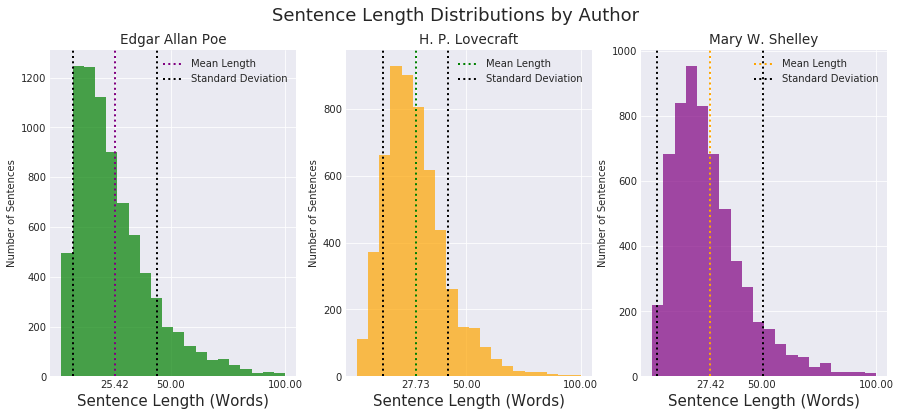

In [6]:
plt.show();

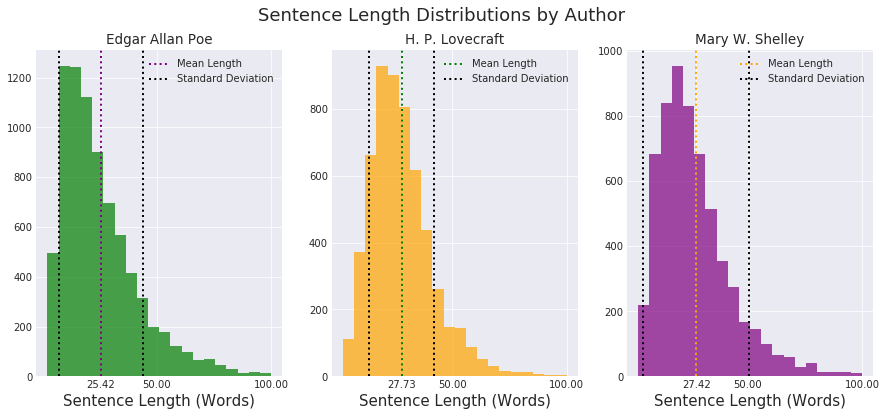

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('Sentence Length Distributions by Author', fontsize=18)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.sentence_length_words <= 100)].sentence_length_words, 
        bins=20,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean() + data[data.author==auth].sentence_length_words.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean() - data[data.author==auth].sentence_length_words.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth], fontsize=13.5);
    ax[i].set_xlabel('Sentence Length (Words)', fontsize=15);
    xtkx = ax[i].get_xticks();
    xtkx = list(xtkx);
    xtkx = list([data[data.author==auth].sentence_length_words.mean()]) + [50, xtkx[6]]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
#plt.tight_layout();
plt.show();

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('Mean Word Length Distribution', fontsize=18)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.mean_word_length <= 10)].mean_word_length, 
        bins=20,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].mean_word_length.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].mean_word_length.mean() + data[data.author==auth].mean_word_length.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].mean_word_length.mean() - data[data.author==auth].mean_word_length.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth])
    ax[i].set_xlabel('Word Length (Words)', fontsize=15)
    ax[i].set_ylabel('Number of Sentences');
    xtkx = ax[i].get_xticks()
    xtkx = list(xtkx)
    xtkx = list([data[data.author==auth].mean_word_length.mean()]) + [10]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
#plt.tight_layout();

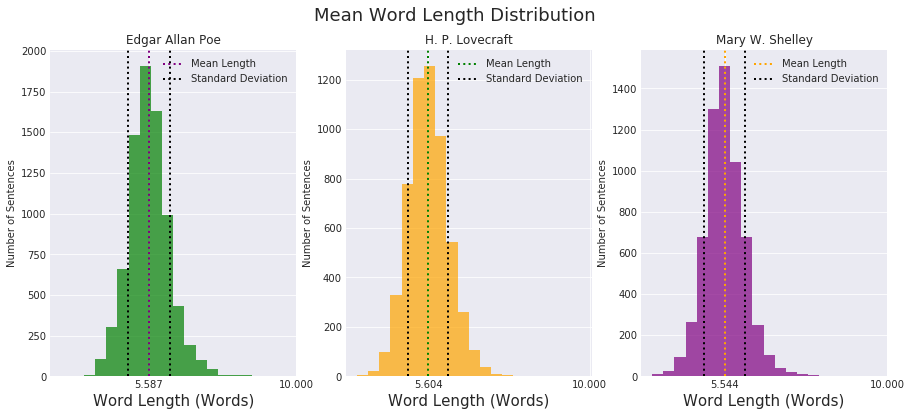

In [9]:
plt.show();

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle('Clauses per Sentence', fontsize=17)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.num_clauses <= 13)].num_clauses, 
        bins=13,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].num_clauses.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].num_clauses.mean() + data[data.author==auth].num_clauses.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].num_clauses.mean() - data[data.author==auth].num_clauses.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth])
    ax[i].set_xlabel('Number of Clauses', fontsize=15)
    ax[i].set_ylabel('Number of Sentences');
    xtkx = ax[i].get_xticks()
    xtkx = list(xtkx)
    xtkx = list([data[data.author==auth].num_clauses.mean()]) + [6, xtkx[5]]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
#plt.tight_layout();

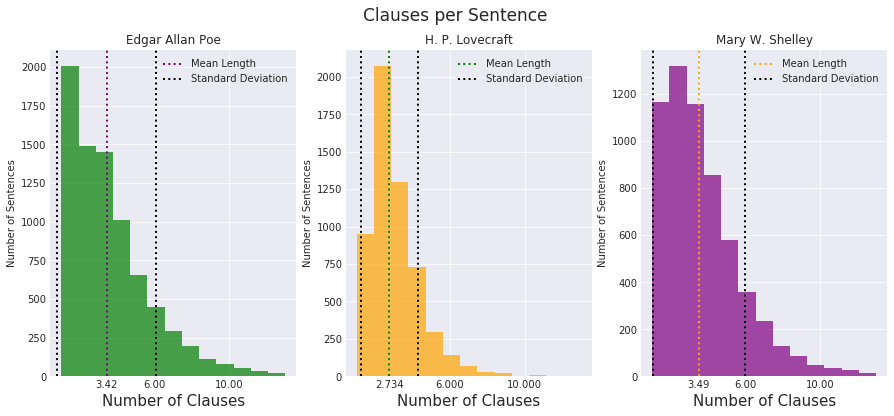

In [11]:
plt.show();

In [12]:
X1 = data[fts]
Y = data.author
logl_score = make_scorer(log_loss, needs_proba=True)
nb1 = BernoulliNB()
t1 = time()
print('Testing NB Model...')
nb1_scores = pd.Series(cross_val_score(nb1, X1, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', nb1_scores.mean(), ' +/- ', nb1_scores.std())
nb1_acc_scores = pd.Series(cross_val_score(nb1, X1, Y, cv=5))
print('5-fold mean accuracy: ', nb1_acc_scores.mean(), ' +/- ', nb1_acc_scores.std())
nb1_time = time() - t1
print('Cross validation completed in: ', nb1_time, ' seconds')

Testing NB Model...
5-fold mean log loss:  1.08385261759  +/-  0.00180627224311
5-fold mean accuracy:  0.403493543207  +/-  4.6089037142e-05
Cross validation completed in:  0.9290320873260498  seconds


In [13]:
logl_score = make_scorer(log_loss, needs_proba=True)
rf1 = RandomForestClassifier(n_estimators=100)
t1 = time()
print('Testing RF Model...')
rf1_scores = pd.Series(cross_val_score(rf1, X1, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', rf1_scores.mean(), ' +/- ', rf1_scores.std())
rf1_time = time() - t1
print('Cross validation completed in: ', rf1_time, ' seconds')
rf1_acc_scores = pd.Series(cross_val_score(rf1, X1, Y, cv=5))
rf1_time = time() - t1
print('5-fold mean accuracy: ', rf1_acc_scores.mean(), ' +/- ', rf1_acc_scores.std())
print('Cross validation completed in: ', rf1_time, ' seconds')

Testing RF Model...
5-fold mean log loss:  2.03640290164  +/-  0.02763985805
Cross validation completed in:  11.39176893234253  seconds
5-fold mean accuracy:  0.424127481714  +/-  0.00675441967682
Cross validation completed in:  22.60260033607483  seconds


In [14]:
bar_width = .2
x = np.arange(2)
times = [rf1_time/5, nb1_time/5]
accs = [rf1_acc_scores.mean(), nb1_acc_scores.mean()]
losses = [rf1_scores.mean(), nb1_scores.mean()]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance on Superficial Features', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) (Seconds/Fold)');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy (Proportion)');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend(fontsize=14);
plt.xlabel('Model', fontsize=18);
plt.xticks(x, ['Random Forest (100 Estimators)', 'Naive Bayes'], fontsize=12);

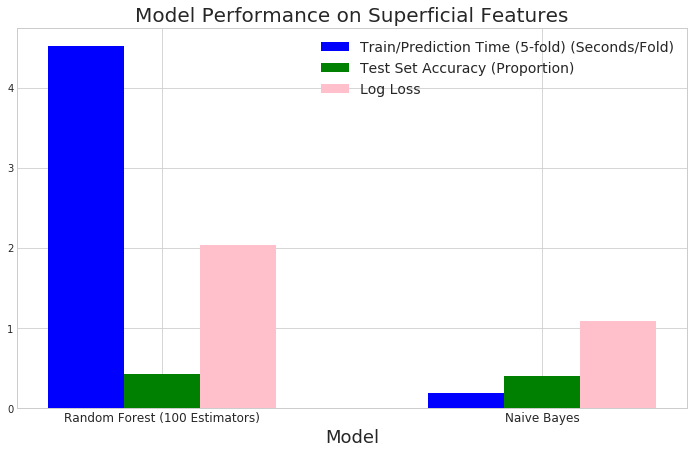

In [15]:
plt.show();

 - Both models come in at around 41% accuracy.
 - Random Forest is slightly more accurate
 - Naive Bayes yields a significantly lower (better) log loss score.

<H1>Model 2: Significant N-Grams</H1>

<b>Concept:</b><br>
Exploit Naive Bayes algorithm to produce high-confidence predictions by selecting informative N-gram count features.

In [16]:
def get_freq_vecs(data, min_freq=3):
    """Takes the dataframe and an optional minimum n-gram frequency and vectorizes the grams
    with CountVectorizer. Calculates a vector with global word frequencies (gram-wise sum
    of gram-count matrix), and an author-specific gram-wise sum. Returns a vector with the
    max and min gram-wise author-specific frequency as a fraction of the total global gram
    frequency.
    Returns a dataframe with the vectorizer vocabulary, a vector with max author-specific freqs,
    a vector with min author-specific freqs, and a vector of global word frequencies.
    """
    eap, hpl, mws = (
        data[data.author=='EAP'].recombined, 
        data[data.author=='HPL'].recombined, 
        data[data.author=='MWS'].recombined
    )

    vec = CountVectorizer(ngram_range=(1, 5), min_df=min_freq, stop_words='english')
    corpus = vec.fit_transform(data.recombined)
    vocab = vec.vocabulary_

    eap, hpl, mws = vec.transform(eap), vec.transform(hpl), vec.transform(mws)

    total_freq = corpus.todense().sum(axis=0)
    eap_freq = eap.todense().sum(axis=0)/total_freq
    hpl_freq = hpl.todense().sum(axis=0)/total_freq
    mws_freq = mws.todense().sum(axis=0)/total_freq

    freqs_max = np.array([eap_freq, hpl_freq, mws_freq]).max(axis=0)
    freqs_min = np.array([eap_freq, hpl_freq, mws_freq]).min(axis=0)

    vocab_frame = pd.DataFrame()
    vocab_frame['items'] = vocab.items()
    vocab_frame['gram'] = vocab_frame['items'].apply(lambda x: x[0])
    vocab_frame.index = vocab_frame['items'].apply(lambda x: x[1])
    return vocab_frame, freqs_max, freqs_min, total_freq
    
def get_best_grams(vocab_frame, freqs_max, freqs_min, freqs_tot, min_df=5, cutoff_min=.25, cutoff_max=.75):
    """Takes output from get_freq_vecs and filters based ona set of criteria:
    
    min_df is the minumum global frequency of a gram to pass the filter.
    grams with minimum author-specific frequencies below cutoff_min are admitted.
    grams with maximum author-specific frequencies above cutoff_max are admitted.
    
    Returns a list of admitted grams.
    """
    top_tier = np.where(freqs_max >= cutoff_max, 1, 0)
    bottom_tier = np.where(freqs_min <= cutoff_min, 1, 0)
    tot = np.where((top_tier + bottom_tier) > 0, True, False)
    tot = np.where(tot & (freqs_tot >= min_df), 1, 0)
    indcs = []
    if len(tot.shape) > 1:
        for i, val in enumerate(tot[0]):
            if val > 0:
                indcs.append(i)
    else:
        for i, val in enumerate(tot):
            if val > 0:
                indcs.append(i) 
    return list(vocab_frame.loc[indcs].gram)

def dynamic_cutoffs(global_freqs, expected_stds, voc, fmax, fmin, ftot, 
                    expected_mean=(1/3), std_scl=2, stop_freq=None, step_=1):
    """Takes a series of global frequencies and a series of "expected" standard devations
    and makes calls on get_best_grams to dynamically adjust cutoff. Collects best grams from
    each search, consolodates and returns them as a list.
    """
    if stop_freq == None:
        stop_ = int(ftot.max())
    else:
        stop_ = stop_freq
    result = []
    it = 0
    for i in range(ftot.min()-1, stop_, step_):
        it += 1
        if it%100==0:
            print('{} out of {} tasks completed.'.format(it, stop_))
        cutoff_flr = expected_mean - (std_scl*expected_stds.loc[i]*(2/3))
        cutoff_cl = expected_mean + (std_scl*expected_stds.loc[i]*(4/3))
        rs = get_best_grams(voc, fmax, fmin, ftot, min_df=global_freqs.loc[i], cutoff_min=cutoff_flr, cutoff_max=cutoff_cl)
        result += rs
    return list(set(result))

<H3>Discussion Terms</H3>
 - <b>N-Gram</b>: a group of n words
 - <b>Corpus</b>: the set of all documents in the dataset (in our case, sentences)
 - <b>Author Corpus</b>: the set of all documents by a given author.
 - <b>N-Gram Document Frequency</b>: the number of times an N-gram appears in the corpus
 - <b>N-Gram Author Frequency</b>: the number of times an N-gram appears in an author corpus
 - <b>N-Gram Partial Author Frequency</b>: the fraction of document frequency from an author.
 - The Partial Author Frequency of an N-Gram is its author frequency divided by its document frequency.
 - The partial author frequency of an N-Gram is alway in range 0 < n < 1.
 
 

<H3>Feature Construction</H3>
 - Count the N-grams that appear in a sentence to convert them into numeric features

<H3>Insignificant N-Grams</H3><br>
We expect the partial author frequency to be roughly 1/3.<br>
Take the word "thought" (unigram) for an example:

In [17]:
vals = {}
vals['EAP'] = 0
vals['HPL'] = 0
vals['MWS'] = 0
for i in data.index:
    row = data.loc[i]
    auth = row.author
    if 'thought' in row.words:
        vals[auth] += 1
nums = [vals['EAP'], vals['HPL'], vals['MWS']]
tot = sum(nums)
plt.figure(figsize=(7, 5))
plt.title('Insignificant Unigram Example: "thought"', fontsize=20)
plt.bar([1, 2, 3], nums, color='green', width=.25);
plt.ylabel('Author Frequency', fontsize=14);
plt.xticks([1, 2, 3], ['Poe', 'Lovecraft', 'Shelley']);
plt.axhline(y=tot/3, linestyle='dotted', color='purple', label='expected author frequency');
plt.legend(fontsize=14)
plt.xlabel('Author', fontsize=14);

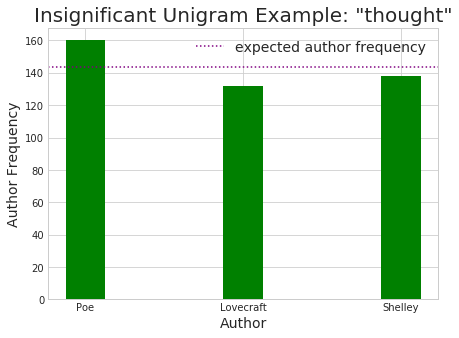

In [18]:
plt.show();

 - "thought" provides very little useful information for our model. 
 - This is the type of N-gram I want to exclude.

<H3>Significant N-Grams</H3>

In [19]:
vals = {}
vals['EAP'] = 0
vals['HPL'] = 0
vals['MWS'] = 0
for i in data.index:
    row = data.loc[i]
    auth = row.author
    if 'abaout' in row.words:
        vals[auth] += 1
nums = [vals['EAP'], vals['HPL'], vals['MWS']]
tot = sum(nums)

In [20]:
plt.figure(figsize=(7, 4))
plt.title('Significant Unigram Example: "abaout"', fontsize=20)
plt.bar([1, 2, 3], nums, color='green', width=.25);
plt.ylabel('Author Frequency of word "abaout"', fontsize=14);
plt.axhline(y=tot/3, linestyle='dotted', color='purple', label='expected author frequency');
plt.xticks([1, 2, 3], ['Poe', 'Lovecraft', 'Shelley']);
plt.yticks([0, 20]);
plt.legend(loc=4);
plt.xlabel('Author', fontsize=14);

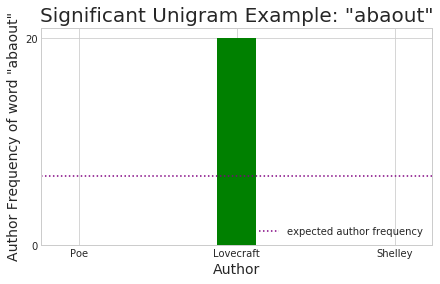

In [21]:
plt.show();

<H3>That's What I'm Talking "Abaout"</H3>
 - Lovecraft uses an unusual spelling of "abaout" that distinguishes him from the other authors.
 - This is the type of N-gram that I want to include.

<H2>Selecting Significant N-Grams</H2>
 - Each N-gram has three partial author frequency values, one for each class.
 - For "abaout", these values are: 0 (EAP), 1 (HPL), 0 (MWS).
 - I use the minimum across these three values as a way to evaluate significance.
 - I call this the <b>minimum partial frequency</b> of an N-gram.
 - The minimum partial frequency for "abaout" is 0.

<H3>Why Minimum?</H3>
 - Why not use maximum partial frequency instead?
 - The sum across partial frequencies is one.
 - When maximum partial frequency is high, it forces the minumum down.

<H4>A low minimum partial frequency occurs in two desirable situations:</H4>
 1. A gram that is heavily used by a particular author
 2. A gram that is rarely used by a particular author

<H2>Filter Method</H2>
 - Define a cutoff ceiling for minimum partial frequency
 - Include only grams that fall below this boundary

<H3>A Small Problem...</H3>
 - This method selects any gram with a document frequency < 3.
 - Grams with low document frequencies are more likely to fall below threshold by chance.

<H2>Solution</H2>
I use random class assignment to estimate an expected standard deviation from the mean minimum partial frequency over document frequency.

In [22]:
exp_devs = pd.read_csv('exp_std_chart.csv')

lk = exp_devs.iloc[:300]
plt.figure(figsize=(8, 5))
plt.title('Standard Deviation of Minimum Partial Frequency')
plt.plot(lk.expected_standard_deviation);
plt.xlabel('Document Frequency');
plt.ylabel('Standard Deviation');

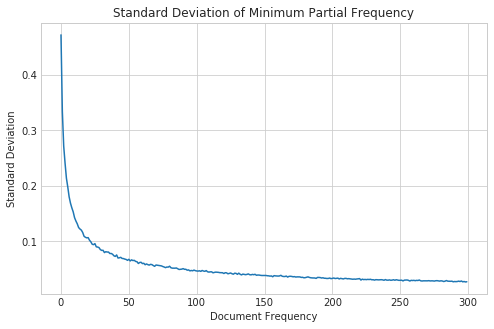

In [23]:
plt.show();

In [24]:
voc, fmax, fmin, ftot = get_freq_vecs(data)
best_grams = dynamic_cutoffs(
    exp_devs.global_frequency, 
    exp_devs.expected_standard_deviation, 
    voc, fmax, fmin, ftot, 
    std_scl=2
)

100 out of 1218 tasks completed.
200 out of 1218 tasks completed.
300 out of 1218 tasks completed.
400 out of 1218 tasks completed.
500 out of 1218 tasks completed.
600 out of 1218 tasks completed.
700 out of 1218 tasks completed.
800 out of 1218 tasks completed.
900 out of 1218 tasks completed.
1000 out of 1218 tasks completed.
1100 out of 1218 tasks completed.
1200 out of 1218 tasks completed.


In [25]:
x = list(np.array(ftot[0, :])[0])
y1 = list(fmin[0, :])
y2 = list(fmax[0, :])
plt.figure(figsize=(10, 7))

plt.title('N-Gram Selection Boundary')
for i in range(0, len(x)):
    gram = str(voc.loc[i][0][0])
    style = 'o'
    color = 'blue'
    if gram in best_grams:
        style = 'x'
        color = 'red'
    plt.scatter(x=x[i], y=y1[i], color=color);
plt.axhline(y=1/3, linestyle='dotted', color='black', label='expected value from random dist.')
lk = exp_devs.iloc[:1240]
plt.plot(
    exp_devs['global_frequency'], 
    (1/3 - ((4/3)*exp_devs['expected_standard_deviation'])),
    color='green',
    linewidth=3,
    label = 'Selection Boundary'
)
plt.scatter(x=1, y=1/6, color='blue', label='N-grams excluded from model');
plt.scatter(x=30, y=1/6, color='red', label='N-grams selected for model');
plt.ylabel('Minimum Partial Frequency');
plt.xlabel('Document Frequency');
plt.xlim((-50, 500))
plt.ylim((-.1, .35))
plt.legend();

<H2>Varying Selection Threshold over Document Frequency</H2>

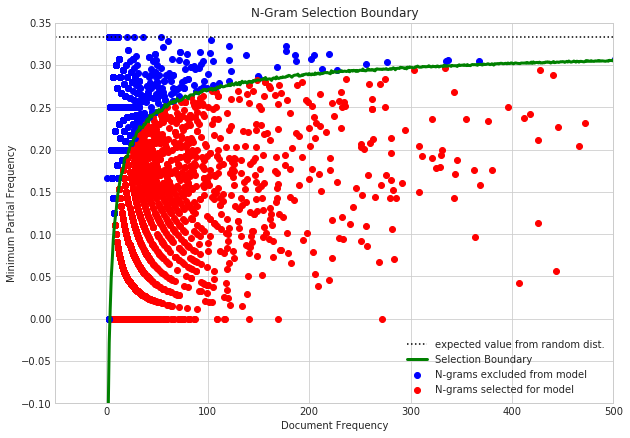

In [26]:
plt.show();

In [27]:
frac = len(best_grams)/len(voc)
print('-'*40)
print('\n{}% of N-grams included in model.\n'.format(str(frac*100)[:5]))
print('Total number of N-grams selected: ', len(best_grams))
print('\n', '-'*40)
best_vec = CountVectorizer(vocabulary=best_grams, ngram_range=(1,5))
best_vec.fit(list())
X2 = best_vec.transform(data.recombined)

----------------------------------------

57.29% of N-grams included in model.

Total number of N-grams selected:  7666

 ----------------------------------------


In [28]:
nb1 = BernoulliNB(alpha=1)
t1 = time()
print('Testing NB Model...')
nb2_scores = pd.Series(cross_val_score(nb1, X2, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', nb2_scores.mean(), ' +/- ', nb2_scores.std())
print('Cross validation completed in: ', time() - t1, ' seconds')
nb2_acc_scores = pd.Series(cross_val_score(nb1, X2, Y, cv=5))
nb2_time = time() - t1
print('5-fold mean accuracy: ', nb2_acc_scores.mean(), ' +/- ', nb2_acc_scores.std())
print('Cross validation completed in: ', nb2_time, ' seconds')

Testing NB Model...
5-fold mean log loss:  0.454842942932  +/-  0.0118676840099
Cross validation completed in:  0.5620725154876709  seconds
5-fold mean accuracy:  0.82828535908  +/-  0.00407474857936
Cross validation completed in:  1.0011699199676514  seconds


In [29]:
rf2 = RandomForestClassifier()
t1 = time()
print('Testing RF Model...')
rf2_scores = pd.Series(cross_val_score(rf2, X2, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', rf2_scores.mean(), ' +/- ', rf2_scores.std())
rf2_acc_scores = pd.Series(cross_val_score(rf1, X2, Y, cv=5))
rf2_time = time() - t1
print('5-fold mean accuracy: ', rf2_acc_scores.mean(), ' +/- ', rf2_acc_scores.std())
print('Cross validation completed in: ', rf2_time, ' seconds')

Testing RF Model...
5-fold mean log loss:  1.65092010249  +/-  0.056492069801
5-fold mean accuracy:  0.691812859318  +/-  0.00406030744899
Cross validation completed in:  221.87574529647827  seconds


In [30]:
bar_width = .2
x = np.arange(2)
times = [rf2_time/300, nb2_time/300]
accs = [rf2_acc_scores.mean(), nb2_acc_scores.mean()]
losses = [rf2_scores.mean(), nb2_scores.mean()]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance with Significant N-Gram Count Features', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (Minutes/fold)');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy (Fraction Correctly Identified)');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, ['Random Forest (100 Estimators)', 'Naive Bayes'], fontsize=12);

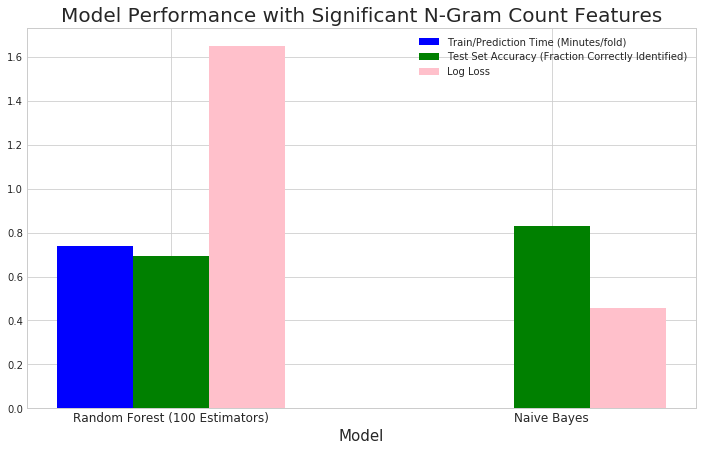

In [31]:
plt.show();

<H1>Model 3: Probabilities from Parts of Speech with Markov Model</H1>

 - Inspiration: I asked a scholar how to approach the problem.
 - She said that a major difference between these authors is the way they form sentences.
 - This is due to the fact that each author is from a different time and/or place:

 1. Poe is an American writing in the early 1800's.
 2. Shelley is English, writing in the early-mid 1800's.
 3. Lovecraft is an American writing in the early 1900's.

<H2>Modeling Sentence Formation</H2>
 - <b>Parts of Speech</b> are things like verbs, nouns, adverbs, etc.
 - Sentence formation involves the <b>order</b> in which parts of speech are used.
 - I use a <b>Markov Model</b> to characterize each author's ordering of parts of speech.

<H3>What is a Markov Model?</H3>
 - It's a computation of probabilities that assumes the <b>Markov Property</b>.
 - The Markov Property asserts that the next state (part of speech) depends <b>only</b> on the previous state.
 - It is an extension of a Naive Bayes model that "considers" the preceding part(s) of speech when computing the probability of the next one.
 - The <b>order</b> of a Markov model is the number of previous states that the model "remembers."

In [32]:
stratCV = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=.10, random_state=1)
train_inds, test_inds = next(stratCV.split(data['text'], data['author']))

train_pos = data.loc[train_inds, 'pos_list'].reset_index(drop=True)
test_pos = data.loc[test_inds, 'pos_list'].reset_index(drop=True)
train_label = data.loc[train_inds, 'author'].reset_index(drop=True)
test_label = data.loc[test_inds, 'author'].reset_index(drop=True)

t1 = time()
pos_dict = dict()
for key in ['tot', 'EAP', 'HPL', 'MWS']:
    pos_dict[key] = []
    
for sentence, author in zip(train_pos, train_label):
    pos_dict['tot'] += sentence
    pos_dict[author] += sentence
    
pos_desc = {
    'CC': 'coord conjunction',
    'CD': 'cardinal digit',
    'DT': 'determiner',
    'EX': 'existential "there"',
    'FW': 'foreign word',
    'IN': 'prep/sub conjunction',
    'JJ': 'adjective',
    'JJR': 'comp. adjective',
    'JJS': 'superl. adjective',
    'LS': 'list marker',
    'MD': 'modal',
    'NN': 'noun, sing.',
    'NNS': 'noun, pl.',
    'NNP': 'proper noun, sing.',
    'NNPS': 'proper noun, pl.',
    'PDT': 'predeterminer',
    'POS': 'possessive "s"',
    'PRP': '1st pronoun',
    'PRP$': 'poss pronoun',
    'RB': 'adverb',
    'RBR': 'comp. adverb',
    'RBS': 'superl. adverb',
    'RP': 'particle',
    'TO': 'inf. "to"',
    'UH': 'interjection',
    'VB': 'inf. verb',
    'VBD': 'verb, past',
    'VBG': 'verb, gerund',
    'VBN': 'verb, past part',
    'VBP': 'verb, sing. pres',
    'VBZ': 'verb, 3rd prs sing pres',
    'WDT': 'wh-determiner',
    'WP': 'wh-pronoun',
    'WP$': 'possessive wh-pronoun',
    'WRB': 'wh-abverb',
    ',': 'comma',
    ':': 'colon',
    ';': 'semitcolon',
    '.': 'period',
    '"': 'quotation',
    "'": 'apostrophe',
    'start': '',
    'end': ''
}

for pos in pos_dict['tot']:
    if pos not in pos_desc:
        pos_desc[pos] = pos

In [33]:
pos_encoder = preprocessing.LabelEncoder()
pos_encoder.fit(pos_dict['tot'] + ['start'])

pos_counts_EAP = np.histogram(pos_encoder.transform(pos_dict['EAP']), range(len(pos_encoder.classes_)+1), density=True)[0]
pos_counts_HPL = np.histogram(pos_encoder.transform(pos_dict['HPL']), range(len(pos_encoder.classes_)+1), density=True)[0]
pos_counts_MWS = np.histogram(pos_encoder.transform(pos_dict['MWS']), range(len(pos_encoder.classes_)+1), density=True)[0]

sorted_pos = np.flipud(np.argsort(pos_counts_EAP + pos_counts_HPL + pos_counts_MWS))

authors = ['EAP', 'HPL', 'MWS']
logPs = []
predictions = []
for i, (sentence, author) in enumerate(zip(test_pos, test_label)):
    poss = sentence
    logP_EAP = sum([np.log(pos_counts_EAP[pos_encoder.classes_ == pos]) for pos in poss])
    logP_HPL = sum([np.log(pos_counts_HPL[pos_encoder.classes_ == pos]) for pos in poss])
    logP_MWS = sum([np.log(pos_counts_MWS[pos_encoder.classes_ == pos]) for pos in poss])
    
    logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))
    predictions.append(authors[np.argmax(logPs[-1])])
    
acc = (test_label == predictions).mean()
marko0_time = time() - t1

In [34]:
bar_width = .2
cutoff = int(len(pos_counts_EAP)/2)
sorted_pos1 = sorted_pos[:cutoff]
x = np.arange(cutoff)

plt.figure(figsize=(12, 7)); 
plt.title('Part of Speech Usage Frequency - Most Common', fontsize=20);
plt.bar(x-bar_width, pos_counts_EAP[sorted_pos1], bar_width, color='green', label='Edgar Allen Poe');
plt.bar(x, pos_counts_MWS[sorted_pos1], bar_width, color='orange', label='Mary Shelley');
plt.bar(x+bar_width, pos_counts_HPL[sorted_pos1], bar_width, color='purple', label='H.P. Lovecraft');
plt.legend();
plt.ylabel('POS Usage Frequency', fontsize=12);
plt.xlabel('Part of Speech', fontsize=15);
plt.xticks(x, [pos_desc[j] for j in['{}'.format(pos_encoder.classes_[i]) for i in sorted_pos1]], fontsize=12, rotation=90);

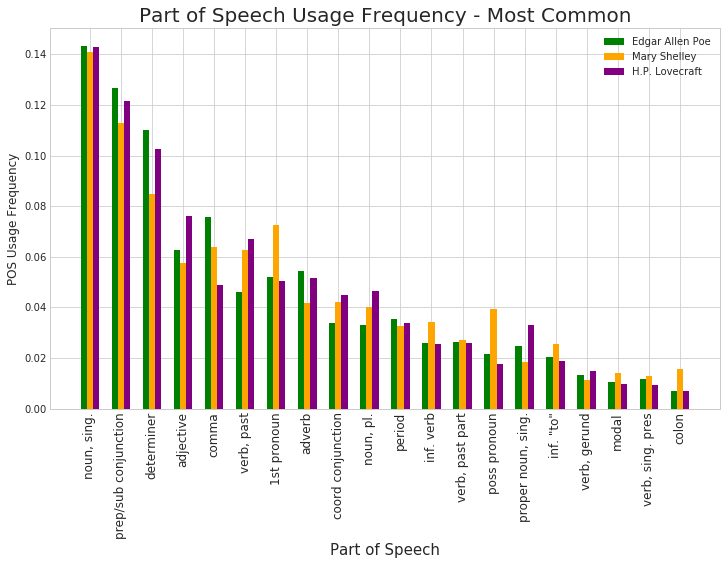

In [35]:
plt.show();

In [36]:
bar_width = .2
cutoff = int(len(pos_counts_EAP)/2)
sorted_pos2 = sorted_pos[cutoff:]
x = np.arange(cutoff)

plt.figure(figsize=(12, 7)); 
plt.title('Part of Speech Usage Frequency - Less Common', fontsize=20);
plt.bar(x-bar_width, pos_counts_EAP[sorted_pos2], bar_width, color='g', label='Edgar Allen Poe');
plt.bar(x, pos_counts_MWS[sorted_pos2], bar_width, color='orange', label='Mary Shelley');
plt.bar(x+bar_width, pos_counts_HPL[sorted_pos2], bar_width, color='purple', label='H.P. Lovecraft');
plt.legend();
plt.ylabel('POS Usage Frequency', fontsize=12);
plt.xlabel('Part of Speech', fontsize=15);
plt.xticks(x, [pos_desc[j] for j in ['{}'.format(pos_encoder.classes_[i]) for i in sorted_pos2]], fontsize=12, rotation=90);

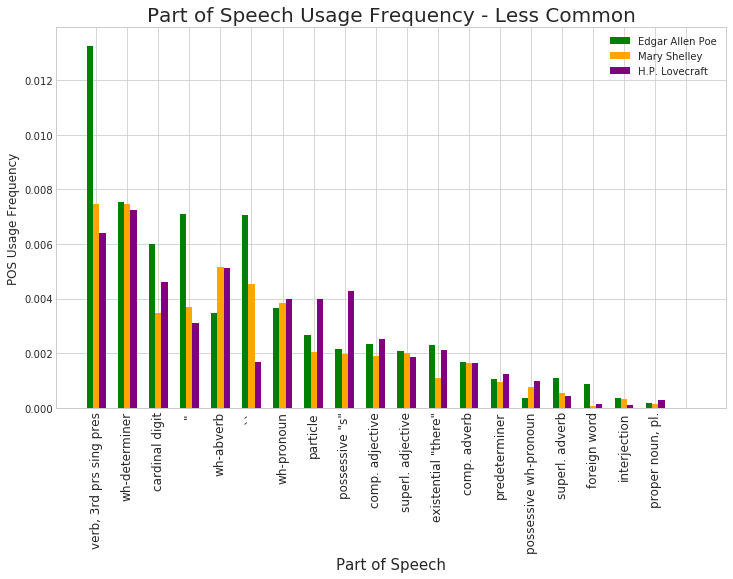

In [37]:
plt.show();


The Markov model expands on the Naive Bayes by using the conditional probability of a part of speech, the condition being the previous one:  
* **no memory** (naive bayes): 
$$P(sentence) = P(a_1)P(a_2)P(a_3)...P(a_n) = \prod_{t=1}^{n}P(a_t)$$ 
* **With the Markov Property, we can write (1st order Markov)**: 
$$P(sentence) = P(a_1)P(a_2|a_1)P(a_3|a_2)...P(a_n|a_{n-1}) = P(a_1)\prod_{t=2}^{n}P(a_t|a_{t-1})$$ 
* **2nd Order (remembers two parts of speech)**: 
$$P(sentence) = P(a_1)P(a_2|a_1)\prod_{t=3}^{n}P(a_t|a_{t-1},a_{t-2})$$ 


In [38]:
print('prediction accuracy on test set: ', str(100*acc)[:4], '%')
Ps = [e**(x) for x in logPs]
Ps = [(1/sum(x)) * x for x in Ps]
probs = np.array(Ps).reshape(1958, 3)
for i, thing in enumerate(probs):
    if np.isnan(thing).any():
        probs[i] = 0
        
loss = log_loss(test_label, probs)
print('log loss on test set: ', str(loss)[:4])

prediction accuracy on test set:  54.8 %
log loss on test set:  0.98


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


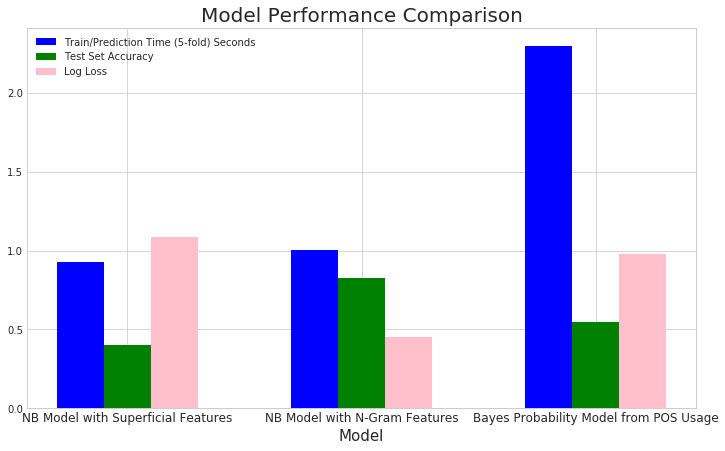

In [39]:
bar_width = .2
x = np.arange(3)
times = [nb1_time, nb2_time, marko0_time]
accs = [nb1_acc_scores.mean(), nb2_acc_scores.mean(), acc]
losses = [nb1_scores.mean(), nb2_scores.mean(), loss]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance Comparison', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) Seconds');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, ['NB Model with Superficial Features', 'NB Model with N-Gram Features', 'Bayes Probability Model from POS Usage'], fontsize=12);
plt.show();

<H2>1st Order Markov Model</H2><br>
Remembers one previous POS state.

In [40]:
order = 1

t1 = time()
history = []
next_pos = []
author = []
for i, (sentence, auth) in enumerate(zip(train_pos, train_label)):
    sentence = ['start'] + sentence
    history += sentence[:-1]
    next_pos += sentence[1:]
    author += [auth]*(len(sentence)-1)
    
corp_df = pd.DataFrame(columns=['author', 'history', 'next_pos'])
corp_df['author'] = author
corp_df['history'] = history
corp_df['next_pos'] = next_pos

pos_cond_prob = {}
for auth in authors:
    pos_cond_prob[auth] = np.zeros( (1+order)*[pos_encoder.classes_.shape[0]])

pos_cond_counts = {}
for auth in authors:
    pos_cond_counts[auth] = np.zeros( (1+order)*[pos_encoder.classes_.shape[0]])    

corp_df_byauth = corp_df.groupby('author', axis=0)
for auth in authors:
    author_corp_df = corp_df_byauth.get_group(auth).loc[:,['history', 'next_pos']].reset_index(drop=True)
    author_corp_byhist = author_corp_df.groupby('history', axis=0)
    for history in author_corp_df.history.unique():
        author_history_df = author_corp_byhist.get_group(history).reset_index(drop=True).loc[:, ['next_pos']].reset_index(drop=True)
        enc_history = pos_encoder.transform([history])[0]
        enc_next_pos_counts = np.histogram(pos_encoder.transform(author_history_df), range(len(pos_encoder.classes_)+1), density=False)[0]
        enc_next_pos_prob = np.histogram(pos_encoder.transform(author_history_df), range(len(pos_encoder.classes_)+1), density=True)[0]
        
        pos_cond_prob[auth][enc_history,:] = enc_next_pos_prob
        pos_cond_counts[auth][enc_history,:] = enc_next_pos_counts
    
pos_cond_prob['all']  = (pos_cond_prob['EAP']  + pos_cond_prob['HPL']  + pos_cond_prob['MWS'] )/3.0
pos_cond_counts['all'] =  pos_cond_counts['EAP'] + pos_cond_counts['HPL'] + pos_cond_counts['MWS']

pos_desc['start'] = 'start of sentence'

auth_prior_frac = .0001
all_prior_frac = .0001

prior = np.array([1 - (auth_prior_frac+all_prior_frac), auth_prior_frac, all_prior_frac])
all_prior_value = 1/len(pos_encoder.classes_)

logPs = []
cond_p_o1 = {}
for auth in authors:
    cond_p_o1[auth] = prior[0]*pos_cond_prob[auth]
    cond_p_o1[auth] += prior[1]*pos_cond_prob['all']
    cond_p_o1[auth] += prior[2]*all_prior_frac
    
predictions = []
for i, (sentence, authoer) in enumerate(zip(test_pos, test_label)):
    pos_sequences = [sentence[i: i + order + 1] for i in range(len(sentence)-order)]
    
    history = [seq[:-1] for seq in pos_sequences]
    next_pos = [seq[-1] for seq in pos_sequences]
    
    logP_EAP = 0
    logP_HPL = 0
    logP_MWS = 0
    
    for hist_pos, nxt in zip(history, next_pos):
        enc_hist_pos = pos_encoder.transform([hist_pos])[0]
        enc_next_pos = pos_encoder.transform([nxt])[0]
        
        logP_EAP += np.log(cond_p_o1['EAP'][enc_hist_pos, enc_next_pos])
        logP_HPL += np.log(cond_p_o1['HPL'][enc_hist_pos, enc_next_pos])
        logP_MWS += np.log(cond_p_o1['MWS'][enc_hist_pos, enc_next_pos])
        
        
    predictions.append(authors[np.argmax([logP_EAP, logP_HPL, logP_MWS])])
    logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))

marko1_time = time() - t1

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
cond_prob = pos_cond_prob['all']

plt.figure(figsize=(12,10))
plt.imshow(cond_prob, cmap='bone');  
plt.colorbar(); 
plt.clim(0,1);
plt.grid('off'); plt.title('Conditional Probability of POS Given Previous - All Authors', fontsize=22);
plt.xlabel('Following Part of Speech', fontsize=18); plt.ylabel('Previous Part of Speech', fontsize=18);
plt.xticks(
    range(cond_prob.shape[0]),
    [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]], 
    rotation=90,
    fontsize=14
);
plt.yticks(
    range(cond_prob.shape[0]),
    [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]],
    fontsize=12
);
plt.tight_layout();

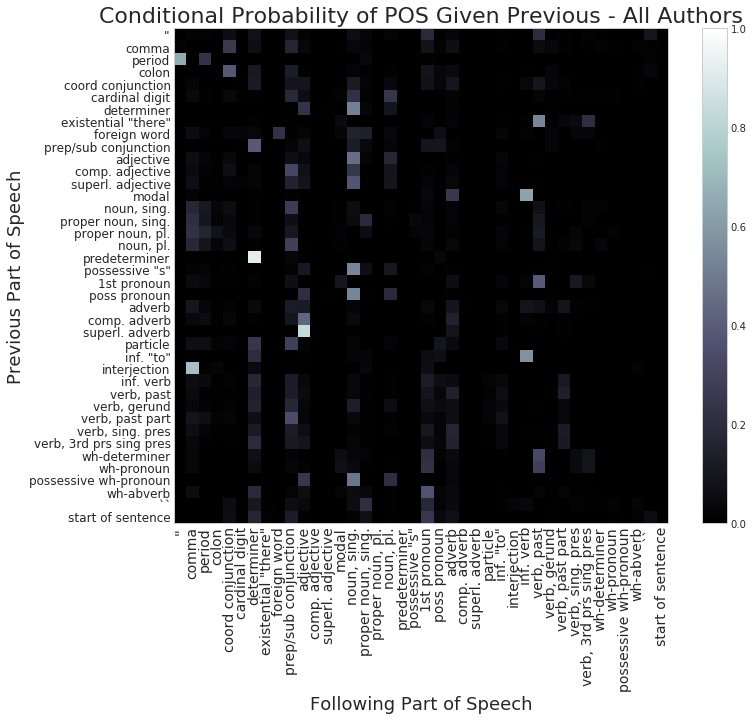

In [42]:
plt.show();

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Conditional Probability for Next POS Given Current (Author-Specific)', fontsize=15)
ax1 = ax[0]
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Edgar Allen Poe', fontsize=13)
ax1.imshow(pos_cond_prob['EAP'], cmap='bone');
ax2 = ax[1]
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('H.P. Lovecraft', fontsize=13)
ax2.imshow(pos_cond_prob['HPL'], cmap='bone');
ax3 = ax[2]
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Mary Shelley', fontsize=13)
ax3.imshow(pos_cond_prob['MWS'], cmap='bone');

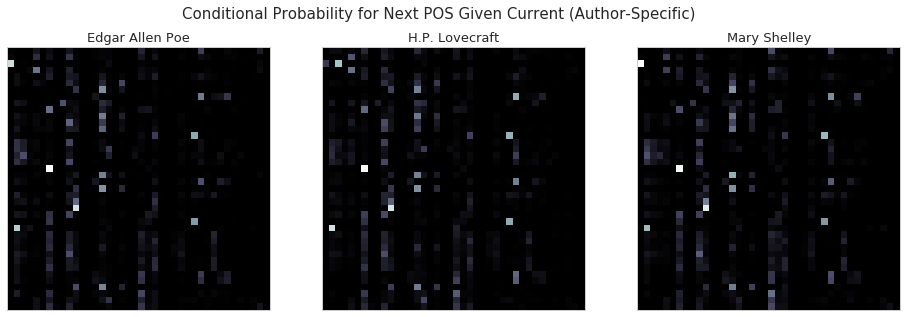

In [44]:
plt.show();

In [45]:
names = {}
names['EAP'] = 'Edgar Allen Poe'
names['HPL'] = 'H.P. Lovecraft'
names['MWS'] = 'Mary Shelley'

plt.figure(figsize=(13,28))
for i, author in enumerate(['EAP','HPL','MWS']):
    cond_prob = pos_cond_prob[author]
    plt.subplot(3,1,i+1); plt.imshow(cond_prob, cmap='bone'); 
    plt.grid('off'); plt.colorbar(); plt.clim(0,1);
    plt.title('{}'.format(names[author]), fontsize=17);
    plt.xlabel('Following Part of Speech', fontsize=15); plt.ylabel('Previous Part of Speech', fontsize=15);
    plt.xticks(
        range(cond_prob.shape[0]),
        [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]],
        rotation = 90
    );
    plt.yticks(
        range(cond_prob.shape[0]),
        [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]]
    );
plt.tight_layout();


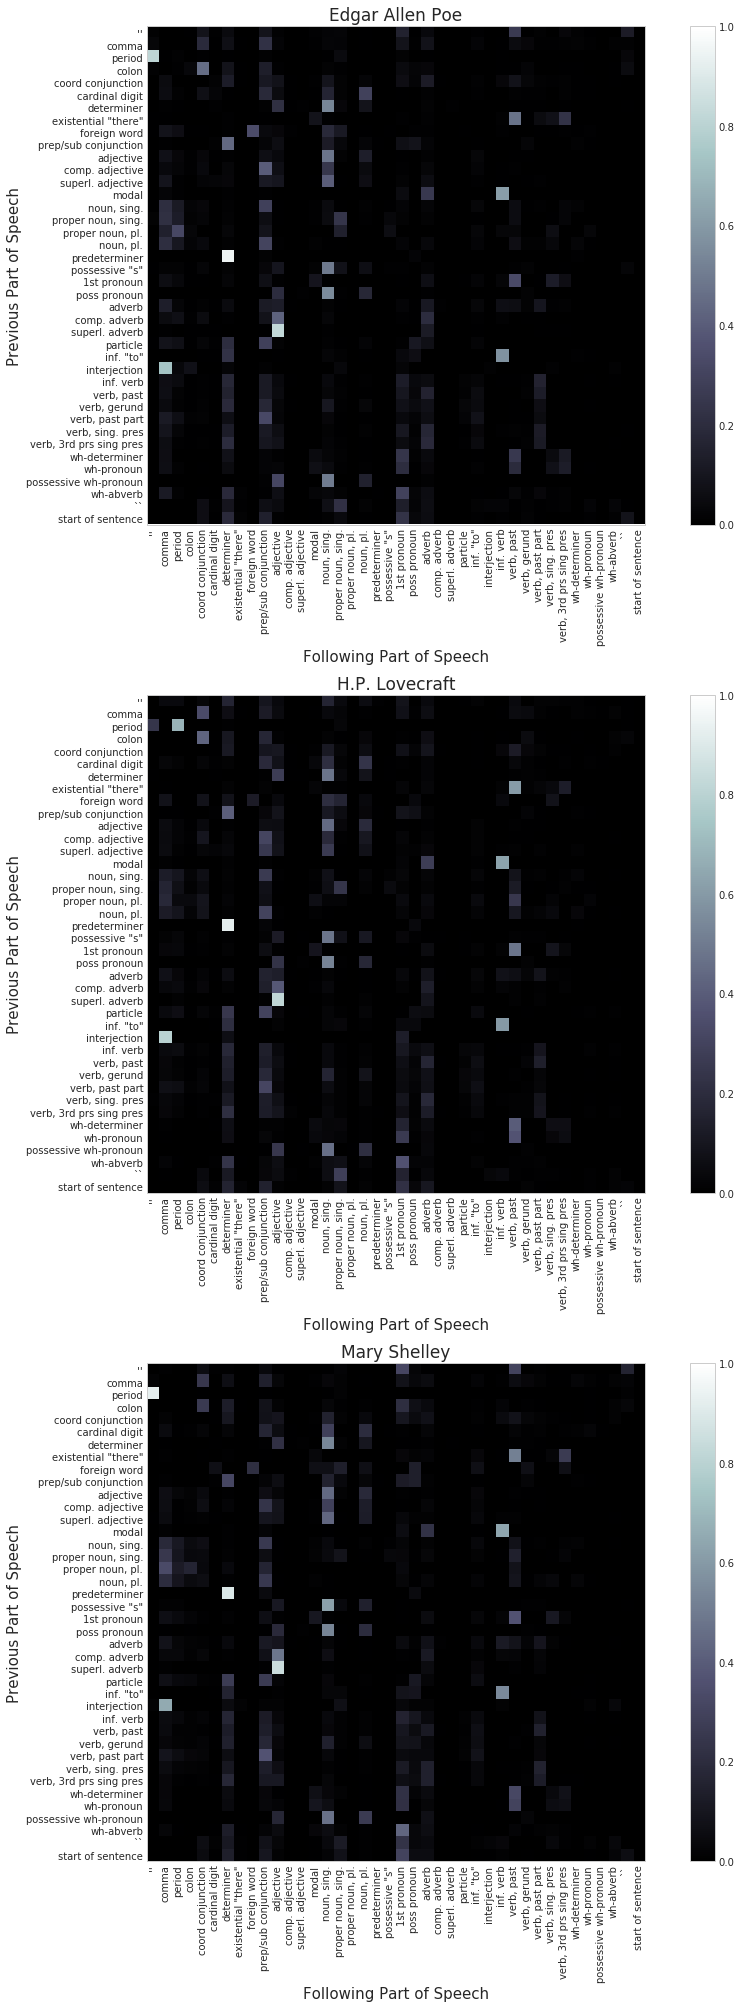

In [46]:
plt.show();

In [47]:
acco1 = (test_label == predictions).mean()
print('prediction accuracy on test set: ', str(100*(acco1))[:4], '%')
logPs = np.array(logPs)
Ps = [e**(x) for x in logPs]
Ps = [(1/sum(x)) * x for x in Ps]
probs = np.array(Ps).reshape(1958, 3)
for i, thing in enumerate(probs):
    if np.isnan(thing).any():
        probs[i] = 0
      
losso1 = log_loss(test_label, probs)
print('log loss on test set: ', str(losso1)[:5])

prediction accuracy on test set:  62.8 %
log loss on test set:  0.932


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


# Using Markov Probabilities to Make Predictions
Markov models are usually used to predict what's coming next. When your phone predicts the word you want to type next, it's using Markov.<br>
In our case, we want to identify the author given the parts of speech in a sentence. We can convert the conditional probabilities using Baye's theorem:

$$P(Author | Sentence) = \frac{P(Sentence | Author)P(Author)}{P(Sentence)}$$  

$P(Author)$ is just the prior probability, or class imbalance.
$P(Sentence)$ is simply 1; thus:

for first order Markov:
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=2}^{n}P(a_t|a_{t-1},Author)P(Author)\}   $$
2nd order:
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=3}^{n}P(a_t|a_{t-1},a_{t-2},Author)P(Author)\}   $$

and so on. This method does not yield a "nice" distribution of probabilities equal to one, so I need to rescale them to get a measurement of confidence.

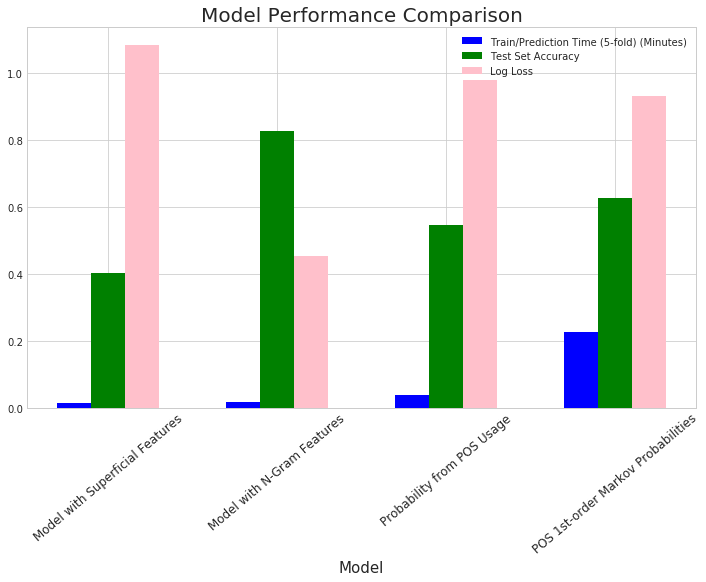

In [48]:
bar_width = .2
x = np.arange(4)
times = [nb1_time/60, nb2_time/60, marko0_time/60, marko1_time/60]
accs = [nb1_acc_scores.mean(), nb2_acc_scores.mean(), acc, acco1]
losses = [nb1_scores.mean(), nb2_scores.mean(), loss, losso1]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance Comparison', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) (Minutes)');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, ['Model with Superficial Features', 'Model with N-Gram Features', 'Probability from POS Usage', 'POS 1st-order Markov Probabilities'], rotation=40, fontsize=12);
plt.show();

<H2>Higher Order Markov Model</H2><br>
Models that remember 2+ previous states.

In [49]:
def get_corpus_df(data, train_inds, order=2):
    """Takes dataframe and integer argument for order of Markov model. Returns a dataframe with
    POS states of length (order), author names, and next state.
    """
    hist_list = []
    nxt_pos_list = []
    author_list = []
    for i, (sentence, author) in enumerate(zip(data.loc[train_inds].pos_list, data.loc[train_inds].author)):
        pos_seqs = [sentence[i:i+order+1] for i in range(len(sentence)-order)]
        history = [seq[:-1] for seq in pos_seqs]
        next_pos = [seq[-1] for seq in pos_seqs]
        
        hist_list += history
        nxt_pos_list += next_pos
        author_list += [author]*len(history)
        
    result = pd.DataFrame(columns=['author', 'history', 'next_pos'])
    result['author'] = author_list
    result['history'] = hist_list
    result.history = result.history.apply(lambda x: tuple(x))
    result['next_pos'] = nxt_pos_list
    return result

def get_models(corpus_df, encoder, order=2):
    """Takes the corpus df output from get_corpus_df, an encoder, and
    order number and returns two dictionaries with three authors and 'all'
    keys corresponding to (1) conditional probability and (2) count matrices for model.
    """
    resultp = {}
    for author in ['EAP','HPL','MWS']:
        resultp[author] = np.zeros( (1+order)*[encoder.classes_.shape[0]] )
    resultc = {}
    for author in ['EAP','HPL','MWS']:
        resultc[author] = np.zeros( (1+order)*[encoder.classes_.shape[0]] )

    corpus_by_author = corpus_df.groupby(by='author',axis=0)
    for author in corpus_df['author'].unique():
        author_corpus_df = corpus_by_author.get_group(author).loc[:,['history','next_pos']].reset_index(drop=True)
        author_corpus_by_history = author_corpus_df.groupby(by='history',axis=0)
        for history in author_corpus_df['history'].unique():
            author_hist_df = author_corpus_by_history.get_group(history).reset_index(drop=True).loc[:,'next_pos'].reset_index(drop=True)
            enc_hist = encoder.transform([pos for pos in history])
            enc_next_pos_counts = np.histogram(encoder.transform(author_hist_df),range(len(encoder.classes_)+1),density=False)[0]
            enc_next_pos_probs   = np.histogram(encoder.transform(author_hist_df),range(len(encoder.classes_)+1),density=True)[0]

            resultp[author][enc_hist[0], enc_hist[1],:] = enc_next_pos_probs
            resultc[author][enc_hist[0], enc_hist[1],:] = enc_next_pos_counts


    resultp['all']  = (resultp['EAP']  + resultp['HPL']  + resultp['MWS'] )/3.0
    resultc['all'] =  resultc['EAP'] + resultc['HPL'] + resultc['MWS']

    return resultp, resultc

def predict_probs2(data, test_inds, prob_mat, encoder, uniform_prior=.1, auth_prior=.1):
    """Takes dataframe, test indices (test_inds), prob & count matrices from get_models, encoder, and 
    optional keyword arguments for priors and order (must match order of input matrices)
    """
    order=2
    logPs = []
    prior = np.array([1.0-uniform_prior-auth_prior, auth_prior, uniform_prior])
    uniform_prior_value = 1.0/len(encoder.classes_)

    condP = {}
    authors_list = ['EAP','HPL','MWS']
    for author in authors_list:
        condP[author]  = prior[0]*prob_mat[author]
        condP[author] += prior[1]*prob_mat['all']
        condP[author] += prior[2]*uniform_prior

    predictions = []
    for i, (sentence, author) in enumerate(zip(data.loc[test_inds].pos_list, data.loc[test_inds].author)):
        pos_seqs = [sentence[i:i+order+1] for i in range(len(sentence)-order)]

        history  = [seq[:-1] for seq in pos_seqs]
        next_pos = [seq[-1] for seq in pos_seqs]

        logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
        for hist_pos, next_pos in zip(history, next_pos):
            enc_hist_pos = encoder.transform([pos for pos in hist_pos])
            enc_next_pos  = encoder.transform([next_pos])[0]

            logP_EAP += np.log(condP['EAP'][enc_hist_pos[0],enc_hist_pos[1],enc_next_pos])
            logP_HPL += np.log(condP['HPL'][enc_hist_pos[0],enc_hist_pos[1],enc_next_pos])
            logP_MWS += np.log(condP['MWS'][enc_hist_pos[0],enc_hist_pos[1],enc_next_pos])

        predictions.append(authors_list[np.argmax([logP_EAP,logP_HPL,logP_MWS])])
        logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))
    acc = (data.loc[test_inds].author == predictions).mean()
    logPs = np.array(logPs)
    Ps = [e**(x) for x in logPs]
    Ps = [(1/sum(x)) * x for x in Ps]
    shp = len(test_inds)
    probs = np.array(Ps).reshape(shp, 3)
    for i, thing in enumerate(probs):
        if np.isnan(thing).any():
            probs[i] = 0
    
    return probs, acc



In [50]:
t1 = time()
corp_df = get_corpus_df(data, train_inds)
pos_cond_prob, pos_cond_counts = get_models(corp_df, pos_encoder, order=2)
probs, acco2 = predict_probs2(data, test_inds, pos_cond_prob, pos_encoder, uniform_prior=.1, auth_prior=.1)
marko2_time = time() - t1
losso2 = log_loss(test_label, probs)
print('accuracy on test set: ', str(acc*100)[:5], '%')
print('log loss on test set: ', str(log_loss(test_label, probs))[:5])

accuracy on test set:  54.80 %
log loss on test set:  0.876


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:92: RuntimeWarning: divide by zero encountered in double_scalars
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:92: RuntimeWarning: invalid value encountered in multiply


In [51]:
def predict_probs3(data, test_inds, prob_mat, encoder, uniform_prior=.1, auth_prior=.1):
    """Takes dataframe, test indices (test_inds), prob & count matrices from get_models, encoder, and 
    optional keyword arguments for priors and order (must match order of input matrices)
    """
    order=3
    logPs = []
    prior = np.array([1.0-uniform_prior-auth_prior, auth_prior, uniform_prior])
    uniform_prior_value = 1.0/len(encoder.classes_)

    condP = {}
    authors_list = ['EAP','HPL','MWS']
    for author in authors_list:
        condP[author]  = prior[0]*prob_mat[author]
        condP[author] += prior[1]*prob_mat['all']
        condP[author] += prior[2]*uniform_prior

    predictions = []
    for i, (sentence, author) in enumerate(zip(data.loc[test_inds].pos_list, data.loc[test_inds].author)):
        pos_seqs = [sentence[i:i+order+1] for i in range(len(sentence)-order)]

        history  = [seq[:-1] for seq in pos_seqs]
        next_pos = [seq[-1] for seq in pos_seqs]

        logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
        for hist_pos, next_pos in zip(history, next_pos):
            enc_hist_pos = encoder.transform([pos for pos in hist_pos])
            enc_next_pos  = encoder.transform([next_pos])[0]

            logP_EAP += np.log(condP['EAP'][enc_hist_pos[0],enc_hist_pos[1],enc_hist_pos[2],enc_next_pos])
            logP_HPL += np.log(condP['HPL'][enc_hist_pos[0],enc_hist_pos[1],enc_hist_pos[2],enc_next_pos])
            logP_MWS += np.log(condP['MWS'][enc_hist_pos[0],enc_hist_pos[1],enc_hist_pos[2],enc_next_pos])

        predictions.append(authors_list[np.argmax([logP_EAP,logP_HPL,logP_MWS])])
        logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))
    acc = (data.loc[test_inds].author == predictions).mean()
    print(52*'-')
    print('==> Tet Set Classification Accuracy = %.1f%s' %(100*acc,'%'))
    print(52*'-')
    logPs = np.array(logPs)
    Ps = [e**(x) for x in logPs]
    Ps = [(1/sum(x)) * x for x in Ps]
    probs = np.array(Ps).reshape(1958, 3)
    for i, thing in enumerate(probs):
        if np.isnan(thing).any():
            probs[i] = 0
    
    return probs, acc

In [52]:
t1 = time()
corp_df = get_corpus_df(data, train_inds, order=3)
pos_cond_prob, pos_cond_counts = get_models(corp_df, pos_encoder, order=3)
probs, acco3 = predict_probs3(data, test_inds, pos_cond_prob, pos_encoder, uniform_prior=10, auth_prior=10)
marko3_time = time() - t1
losso3 = log_loss(test_label, probs)
print('log loss on test set: ', str(log_loss(test_label, probs))[:5])

----------------------------------------------------
==> Tet Set Classification Accuracy = 30.4%
----------------------------------------------------
log loss on test set:  1.132


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in power
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in multiply


In [53]:
bar_width = .2
x = np.arange(4)
times = [marko0_time/60, marko1_time/60, marko2_time/60, marko3_time/60]
accs = [acc, acco1, acco2, acco3]
losses = [loss, losso1, losso2, losso3]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance Comparison', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (minutes/fold)');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, 
           [
               'Prob from POS Usage (order 0)', 
               '1st-order Markov Prob',
               '2nd-order Markov Prob',
               '3rd-order Markov Prob'
           ], 
           rotation=40, 
           fontsize=12
);


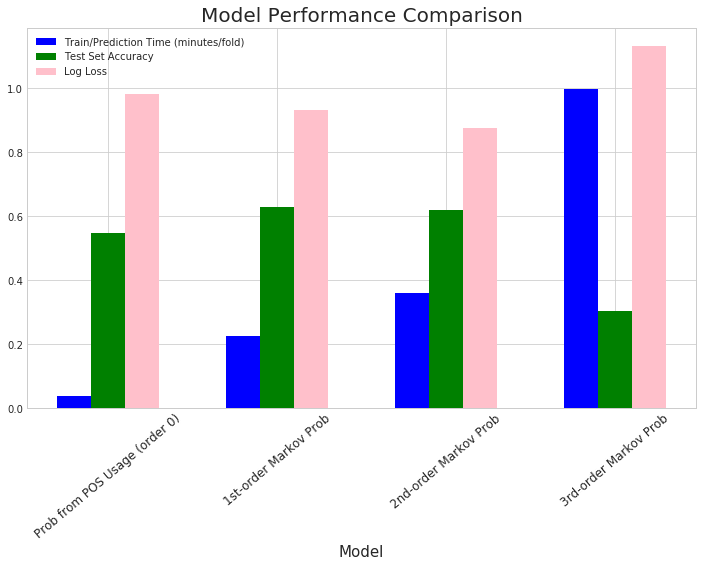

In [54]:
plt.show();

<H1>Ensembling the Models</H1><br>
The ensembling method is to use each model to make a prediction and use the prediction with the highest maximum probability for any single author as our prediction. This means that, for each prediction, one model will "win" and the winner is used as our final prediction.

In [55]:
df = data[['id', 'text', 'author']].copy()

In [56]:
def prepare_data(data):
    """Calls data prep functions and returns appended df,
    list of features used in first model.
    """
    res = data
    res = tokenize_text(res)
    res, fts = build_features(res)
    res = lemmatize_text(res)
    return res, fts

def apply_model_1(df, itrain, itest, fts):
    """takes dataframe, train indices, test indices, and list
    of feature names used in first model. Returns a dataframe
    with probabilities for each author for the test set.
    """
    mod = BernoulliNB()
    mod.fit(df[fts].loc[itrain], df.author.loc[itrain])
    cls = mod.classes_
    probs = mod.predict_proba(df[fts].loc[itest])
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob1'.format(clas) for clas in cls])
    return res

def apply_model_2(df, itrain, itest, vec):
    """takes dataframe, train indices, test indices, and word vectorizer
    from second model. Returns a dataframe
    with probabilities for each author for the test set.
    """
    mod = BernoulliNB()
    X_train = vec.transform(df.recombined.loc[itrain])
    X_test = vec.transform(df.recombined.loc[itest])
    mod.fit(X_train, df.author.loc[itrain])
    cls = mod.classes_
    probs = mod.predict_proba(X_test)
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob2'.format(clas) for clas in cls])
    return res

def apply_model_3(df, itrain, itest, encoder):
    """takes dataframe, train indices, test indices, and encoder
    from third model. Returns a dataframe with probabilities for 
    each author for the test set.
    """
    corp_df = get_corpus_df(df, train_inds)
    pos_cond_prob, pos_cond_counts = get_models(corp_df, encoder, order=2)
    probs, acco2 = predict_probs2(data, itest, pos_cond_prob, encoder, uniform_prior=.1, auth_prior=.1)
    cls = ['EAP', 'HPL', 'MWS']
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob3'.format(clas) for clas in cls])
    return res

In [57]:
fld = StratifiedKFold(n_splits=5, random_state=123)
df, fts = prepare_data(df)
res1, res2, res3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for itrain, itest in fld.split(df['text'], df['author']):
    print('Starting fold...')
    res1 = pd.concat([res1, apply_model_1(df, itrain, itest, fts)], axis=0)
    res2 = pd.concat([res2, apply_model_2(df, itrain, itest, best_vec)], axis=0)
    res3 = pd.concat([res3, apply_model_3(df, itrain, itest, pos_encoder)], axis=0)
    
results = pd.concat([res1, res2, res3], axis=1)

Starting fold...
Starting fold...


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:92: RuntimeWarning: divide by zero encountered in double_scalars
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:92: RuntimeWarning: invalid value encountered in multiply


Starting fold...
Starting fold...
Starting fold...


In [67]:
results['most_confident'] = pd.Series([x[-1] for x in results.idxmax(axis=1)]).astype(int)
plt.figure(figsize=(5, 5))
plt.bar([1,2,3], results.most_confident.value_counts());
plt.title('Models Selected by Ensembler', fontsize=15);
plt.xticks([1, 2, 3], ['N-Gram Counts', '2nd Order Markov Model', 'Superficial Features'], rotation=25);
plt.yticks([5000, 10000, 15000]);
plt.ylabel('Numer of "winning" predictions', fontsize=12);

ValueError: invalid literal for int() with base 10: 't'

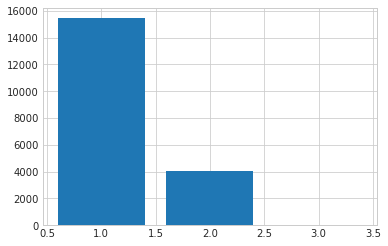

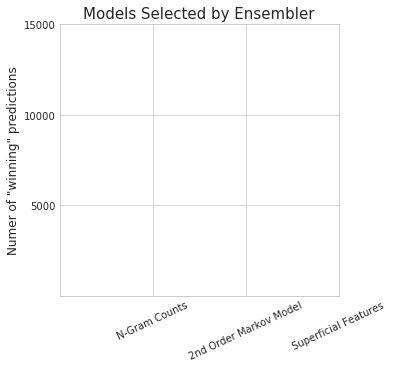

In [59]:
plt.show();

In [60]:
ensemble_predictions = pd.DataFrame(index=df.index, columns=['EAP', 'MWS', 'HPL'])
ensemble_predictions[['EAP', 'MWS', 'HPL']] = 0
for i in df.index:
    winner = int(results.loc[i].most_confident)
    ensemble_predictions.set_value(i, 'EAP', results['EAP_prob{}'.format(winner)].loc[i])
    ensemble_predictions.set_value(i, 'MWS', results['MWS_prob{}'.format(winner)].loc[i])
    ensemble_predictions.set_value(i, 'HPL', results['HPL_prob{}'.format(winner)].loc[i])
    

In [61]:
Y_true = df.author
Y_pred = ensemble_predictions[['EAP', 'HPL', 'MWS']]
ens_loss = log_loss(Y_true, Y_pred)
print(ens_loss)

0.382677228333


In [62]:
Y_true = df.author
Y_pred = res2[['EAP_prob2', 'HPL_prob2', 'MWS_prob2']]
nb2_loss = log_loss(Y_true, Y_pred)

In [63]:
ensemble_predictions['pred_auth'] = ensemble_predictions[['EAP', 'HPL', 'MWS']].idxmax(axis=1)
ensemble_predictions['true_auth'] = df.author
ensemble_predictions['winning_model'] = results.most_confident
ensemble_predictions['correct'] = np.where((ensemble_predictions.pred_auth==ensemble_predictions.true_auth), 1, 0)

In [64]:
ens_acc = ensemble_predictions.correct.sum()/len(ensemble_predictions)

In [65]:
bar_width = .2
x = np.arange(3)
accs = [nb2_acc_scores.mean(), acco2, ens_acc]
losses = [nb2_loss, losso2, ens_loss]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Ensemble Performance Comparison', fontsize=20);
plt.bar(x-bar_width/2, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width/2, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, 
           [ 
               'NB with Significant N-Grams',
               '2nd-order Markov Model',
               'Ensemble Performance'
           ], 
           rotation=40, 
           fontsize=12
);

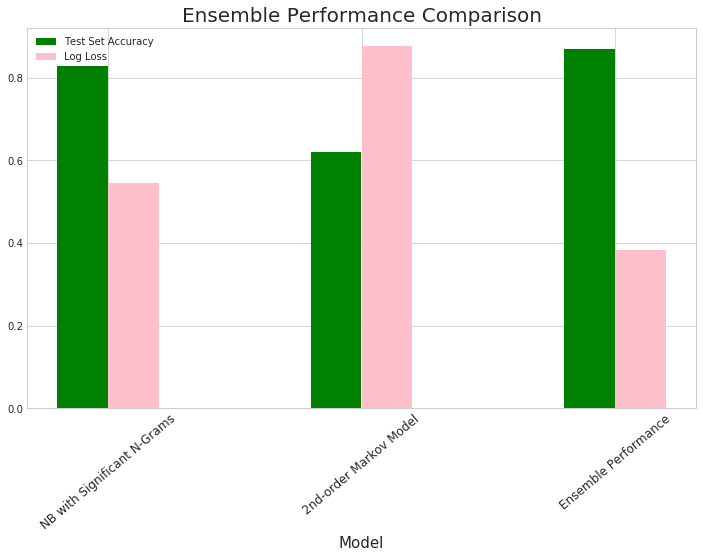

In [66]:
plt.show();

<img src='Kaggle_score.png'>